In [1]:
# test.py
import os
import glob
import random
import torch
import numpy as np
from scipy.ndimage import median_filter, gaussian_filter
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# ===================================================
# 1. Device Setup
# ===================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ===================================================
# 2. Data Preprocessing
# ===================================================
# A. Joint Transform for paired augmentation.
class JointTransform:
    def __init__(self, size=(512, 512)):
        self.size = size
    def __call__(self, seg, height):
        seg = seg.resize(self.size, Image.BICUBIC)
        height = height.resize(self.size, Image.BICUBIC)
        # Random flips for augmentation
        if random.random() > 0.5:
            seg = seg.transpose(Image.FLIP_LEFT_RIGHT)
            height = height.transpose(Image.FLIP_LEFT_RIGHT)
        if random.random() > 0.5:
            seg = seg.transpose(Image.FLIP_TOP_BOTTOM)
            height = height.transpose(Image.FLIP_TOP_BOTTOM)
        return seg, height

In [4]:
# B. Segmentation Transform: Convert to Tensor and Normalize to roughly [-1, 1].
transform_seg = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
# C. Refined Height Transform Function.
def refined_height_transform(x):
    """
    Processes the height map (after ToTensor):
      1. Clamp raw values to [0, 200]
      2. Apply log transform
      3. Clamp the log-transformed values to [-4.0, 0.5]
    """
    x = torch.clamp(x, 0, 200)
    x = torch.log(x + 1e-6)
    x = torch.clamp(x, min=-4.0, max=0.5)
    return x

In [6]:
# D. Create a raw transform (without normalization) for computing statistics.
raw_refined_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: refined_height_transform(x))
])
# Temporarily, use the raw transform.
transform_height = raw_refined_transform

In [7]:
# These normalization parameters must match those computed during training.
height_mean = -1.1637470722198486
height_std  = 1.797243595123291

final_height_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: refined_height_transform(x)),
    transforms.Normalize((height_mean,), (height_std,))
])

In [8]:
# ================================
# 2. Height‐map transforms & stats
# ================================
def refined_height_transform(x):
    x = torch.clamp(x, 0, 200)
    x = torch.log(x + 1e-6)
    x = torch.clamp(x, -4.0, 0.5)
    return x

# raw (log‐clamped) transform
raw_refined = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(refined_height_transform)
])

In [9]:
# # we need the mean/std used at training time:
# # either hardcode from your train.py printout, or recompute on a small subset.
# # here we recompute on 100 samples of the same folder:
# class HeightStatsDataset(Dataset):
#     def __init__(self, folder):
#         self.files = sorted(glob.glob(os.path.join(folder, '*_h.png')))
#     def __len__(self): return len(self.files)
#     def __getitem__(self, i):
#         img = Image.open(self.files[i]).convert('L')
#         return raw_refined(img)

# def compute_height_stats(folder, n=100):
#     ds = HeightStatsDataset(folder)
#     loader = DataLoader(ds, batch_size=16, shuffle=False)
#     vals = []
#     for i, h in enumerate(loader):
#         vals.append(h.view(h.size(0), -1))
#         if (i+1)*loader.batch_size >= n:
#             break
#     vals = torch.cat(vals, 0)
#     return vals.mean().item(), vals.std().item()

In [10]:
# # point this at your dataset folder:
# DATASET_FOLDER = r"dataset\_dataset"
# h_mean, h_std = compute_height_stats(DATASET_FOLDER)
# print(f"Height‐map log‐space mean={h_mean:.4f}, std={h_std:.4f}")

# # normalized transform for model input
# norm_refined = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(refined_height_transform),
#     transforms.Normalize((h_mean,), (h_std,))
# ])

# # segmentation transform
# transform_seg = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
# ])

In [14]:
# ===================================================
# 3. Dataset Definition (same as in train.py)
# ===================================================
class TerrainDataset(Dataset):
    def __init__(self, folder, joint_transform=None, transform_seg=None, transform_height=None):
        self.folder = folder
        self.seg_files = sorted(glob.glob(os.path.join(folder, '*_i2.png')))
        self.height_files = sorted(glob.glob(os.path.join(folder, '*_h.png')))
        assert len(self.seg_files) == len(self.height_files), "Mismatch between segmentation and height images."
        self.joint_transform = joint_transform
        self.transform_seg = transform_seg
        self.transform_height = transform_height
    def __len__(self):
        return len(self.seg_files)
    def __getitem__(self, idx):
        seg_img = Image.open(self.seg_files[idx]).convert('RGB')
        height_img = Image.open(self.height_files[idx]).convert('L')
        if self.joint_transform:
            seg_img, height_img = self.joint_transform(seg_img, height_img)
        if self.transform_seg:
            seg_img = self.transform_seg(seg_img)
        if self.transform_height:
            height_img = self.transform_height(height_img)
        return seg_img, height_img

# Use the same dataset folder as in train.py.
dataset_folder = r"dataset/_dataset"
test_dataset = TerrainDataset(
    folder=dataset_folder,
    joint_transform=JointTransform(),
    transform_seg=transform_seg,
    transform_height=final_height_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=True)

In [ ]:
# # ================================
# # 3. Test Dataset
# # ================================
# class TestDataset(Dataset):
#     def __init__(self, folder):
#         self.seg_files = sorted(glob.glob(os.path.join(folder, '*_i2.png')))
#         self.h_files   = sorted(glob.glob(os.path.join(folder, '*_h.png')))
#         assert len(self.seg_files)==len(self.h_files)
#     def __len__(self):
#         return len(self.seg_files)
#     def __getitem__(self, idx):
#         seg = Image.open(self.seg_files[idx]).convert('RGB')
#         h   = Image.open(self.h_files[idx]).convert('L')
#         seg_t   = transform_seg(seg)
#         h_norm  = norm_refined(h)
#         h_raw   = raw_refined(h)
#         return seg_t, h_norm, h_raw

# test_ds = TestDataset(DATASET_FOLDER)
# test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [15]:
# ===================================================
# 4. Model Definitions
# ===================================================
class ResidualBlock(nn.Module):
    def __init__(self, c): 
        super().__init__()
        self.conv1 = nn.Conv2d(c, c, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(c)
        self.conv2 = nn.Conv2d(c, c, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(c)
        self.relu  = nn.ReLU(True)
    def forward(self, x):
        r = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return self.relu(x + r)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.InstanceNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.InstanceNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.InstanceNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(True)
    def forward(self, g, x):
        g1 = self.W_g(g); x1 = self.W_x(x)
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=True)
        psi = self.relu(g1 + x1); psi = self.psi(psi)
        return x * psi

class AttentionUNetGenerator(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, f=64):
        super().__init__()
        self.down1 = self._down(in_ch, f, norm=False)
        self.down2 = self._down(f, f*2)
        self.down3 = self._down(f*2, f*4)
        self.down4 = self._down(f*4, f*8)
        self.bott = nn.Sequential(
            nn.Conv2d(f*8, f*16, 3, padding=1), nn.InstanceNorm2d(f*16), nn.ReLU(True),
            ResidualBlock(f*16), ResidualBlock(f*16)
        )
        self.up4 = nn.ConvTranspose2d(f*16, f*8, 3, stride=1, padding=1)
        self.att4 = AttentionGate(F_g=f*8, F_l=f*8, F_int=f*4)
        self.up3 = self._up(f*16, f*4)
        self.att3 = AttentionGate(F_g=f*4, F_l=f*4, F_int=f*2)
        self.up2 = self._up(f*8, f*2)
        self.att2 = AttentionGate(F_g=f*2, F_l=f*2, F_int=f)
        self.up1 = self._up(f*4, f*2)
        self.up0 = self._up(f*3, f*2)
        self.final = nn.Sequential(nn.Conv2d(f*2, out_ch, 1), nn.Hardtanh(-1, 1))

    def _down(self, ic, oc, norm=True):
        layers = [nn.Conv2d(ic, oc, 4, 2, 1)]
        if norm:
            layers.append(nn.InstanceNorm2d(oc))
        layers.append(nn.LeakyReLU(0.2, True))
        return nn.Sequential(*layers)

    def _up(self, ic, oc):
        return nn.Sequential(
            nn.ConvTranspose2d(ic, oc, 4, 2, 1),
            nn.InstanceNorm2d(oc),
            nn.ReLU(True)
        )

    def forward(self, x):
        d1 = self.down1(x)                     
        d2 = self.down2(d1)                    
        d3 = self.down3(d2)                    
        d4 = self.down4(d3)                    
        b  = self.bott(d4)                     

        u4 = self.up4(b)                       
        d4a = self.att4(g=u4, x=d4)
        if d4a.shape[2:] != u4.shape[2:]:
            d4a = F.interpolate(d4a, size=u4.shape[2:], mode='bilinear', align_corners=False)
        u4c = torch.cat([u4, d4a], dim=1)      

        u3 = self.up3(u4c)                     
        d3a = self.att3(g=u3, x=d3)
        if d3a.shape[2:] != u3.shape[2:]:
            d3a = F.interpolate(d3a, size=u3.shape[2:], mode='bilinear', align_corners=False)
        u3c = torch.cat([u3, d3a], dim=1)      

        u2 = self.up2(u3c)                     
        d2a = self.att2(g=u2, x=d2)
        if d2a.shape[2:] != u2.shape[2:]:
            d2a = F.interpolate(d2a, size=u2.shape[2:], mode='bilinear', align_corners=False)
        u2c = torch.cat([u2, d2a], dim=1)      

        u1 = self.up1(u2c)                     
        if d1.shape[2:] != u1.shape[2:]:
            d1 = F.interpolate(d1, size=u1.shape[2:], mode='bilinear', align_corners=False)
        u1c = torch.cat([u1, d1], dim=1)       

        u0 = self.up0(u1c)                     
        out = self.final(u0)                   
        return out


In [16]:
netG = AttentionUNetGenerator().to(device)

In [17]:
# ===================================================
# 7. Load Checkpoint for Validation
# ===================================================
ckpt_dir = r"Checkpoints_1"
# checkpoint_path = os.path.join(ckpt_dir, "checkpoints\checkpoint_epoch_510.pth")
checkpoint_path = r"Checkpoints_1\checkpoint_epoch_470.pth"
if os.path.exists(checkpoint_path):
    print("Loading checkpoint for validation...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    # Instantiate models first
    netG = AttentionUNetGenerator(in_ch=3, out_ch=1, f=64).to(device)
    netG.load_state_dict(checkpoint["netG_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resumed at epoch {start_epoch}")
else:
    print("Checkpoint not found. Exiting.")
    exit()

netG.eval()

Loading checkpoint for validation...
Resumed at epoch 471


AttentionUNetGenerator(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (bott): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3)

In [18]:
# ===================================================
# 6. Denormalization Function for Visualization
# ===================================================
def denormalize_height_map(tensor):
    """
    Inverse normalization: Given final transform was:
         ToTensor -> refined_height_transform -> Normalize((height_mean,), (height_std,))
    Invert as: x_denorm = (x * height_std) + height_mean, then apply exp() to approximate the inverse of log,
    and clamp to [0, 200] for the original scale.
    """
    x = tensor * height_std + height_mean
    x = torch.exp(x)
    x = torch.clamp(x, 0, 200)
    return x

Sample 1 -- Generated (post-proc): min=0.9087, max=1.0000, mean=1.0000, std=0.0004
Sample 1 -- Real: min=1.0000, max=1.0000, mean=1.0000, std=0.0000
Sample 2 -- Generated (post-proc): min=0.0518, max=1.0000, mean=0.8943, std=0.2930
Sample 2 -- Real: min=0.0183, max=1.0000, mean=0.8869, std=0.3096
Sample 3 -- Generated (post-proc): min=0.9442, max=1.0000, mean=1.0000, std=0.0003
Sample 3 -- Real: min=1.0000, max=1.0000, mean=1.0000, std=0.0000
Sample 4 -- Generated (post-proc): min=0.0518, max=1.0000, mean=0.7020, std=0.4378
Sample 4 -- Real: min=0.0183, max=1.0000, mean=0.6917, std=0.4543
Sample 5 -- Generated (post-proc): min=0.0518, max=1.0000, mean=0.8979, std=0.2896
Sample 5 -- Real: min=0.0183, max=1.0000, mean=0.8959, std=0.2994


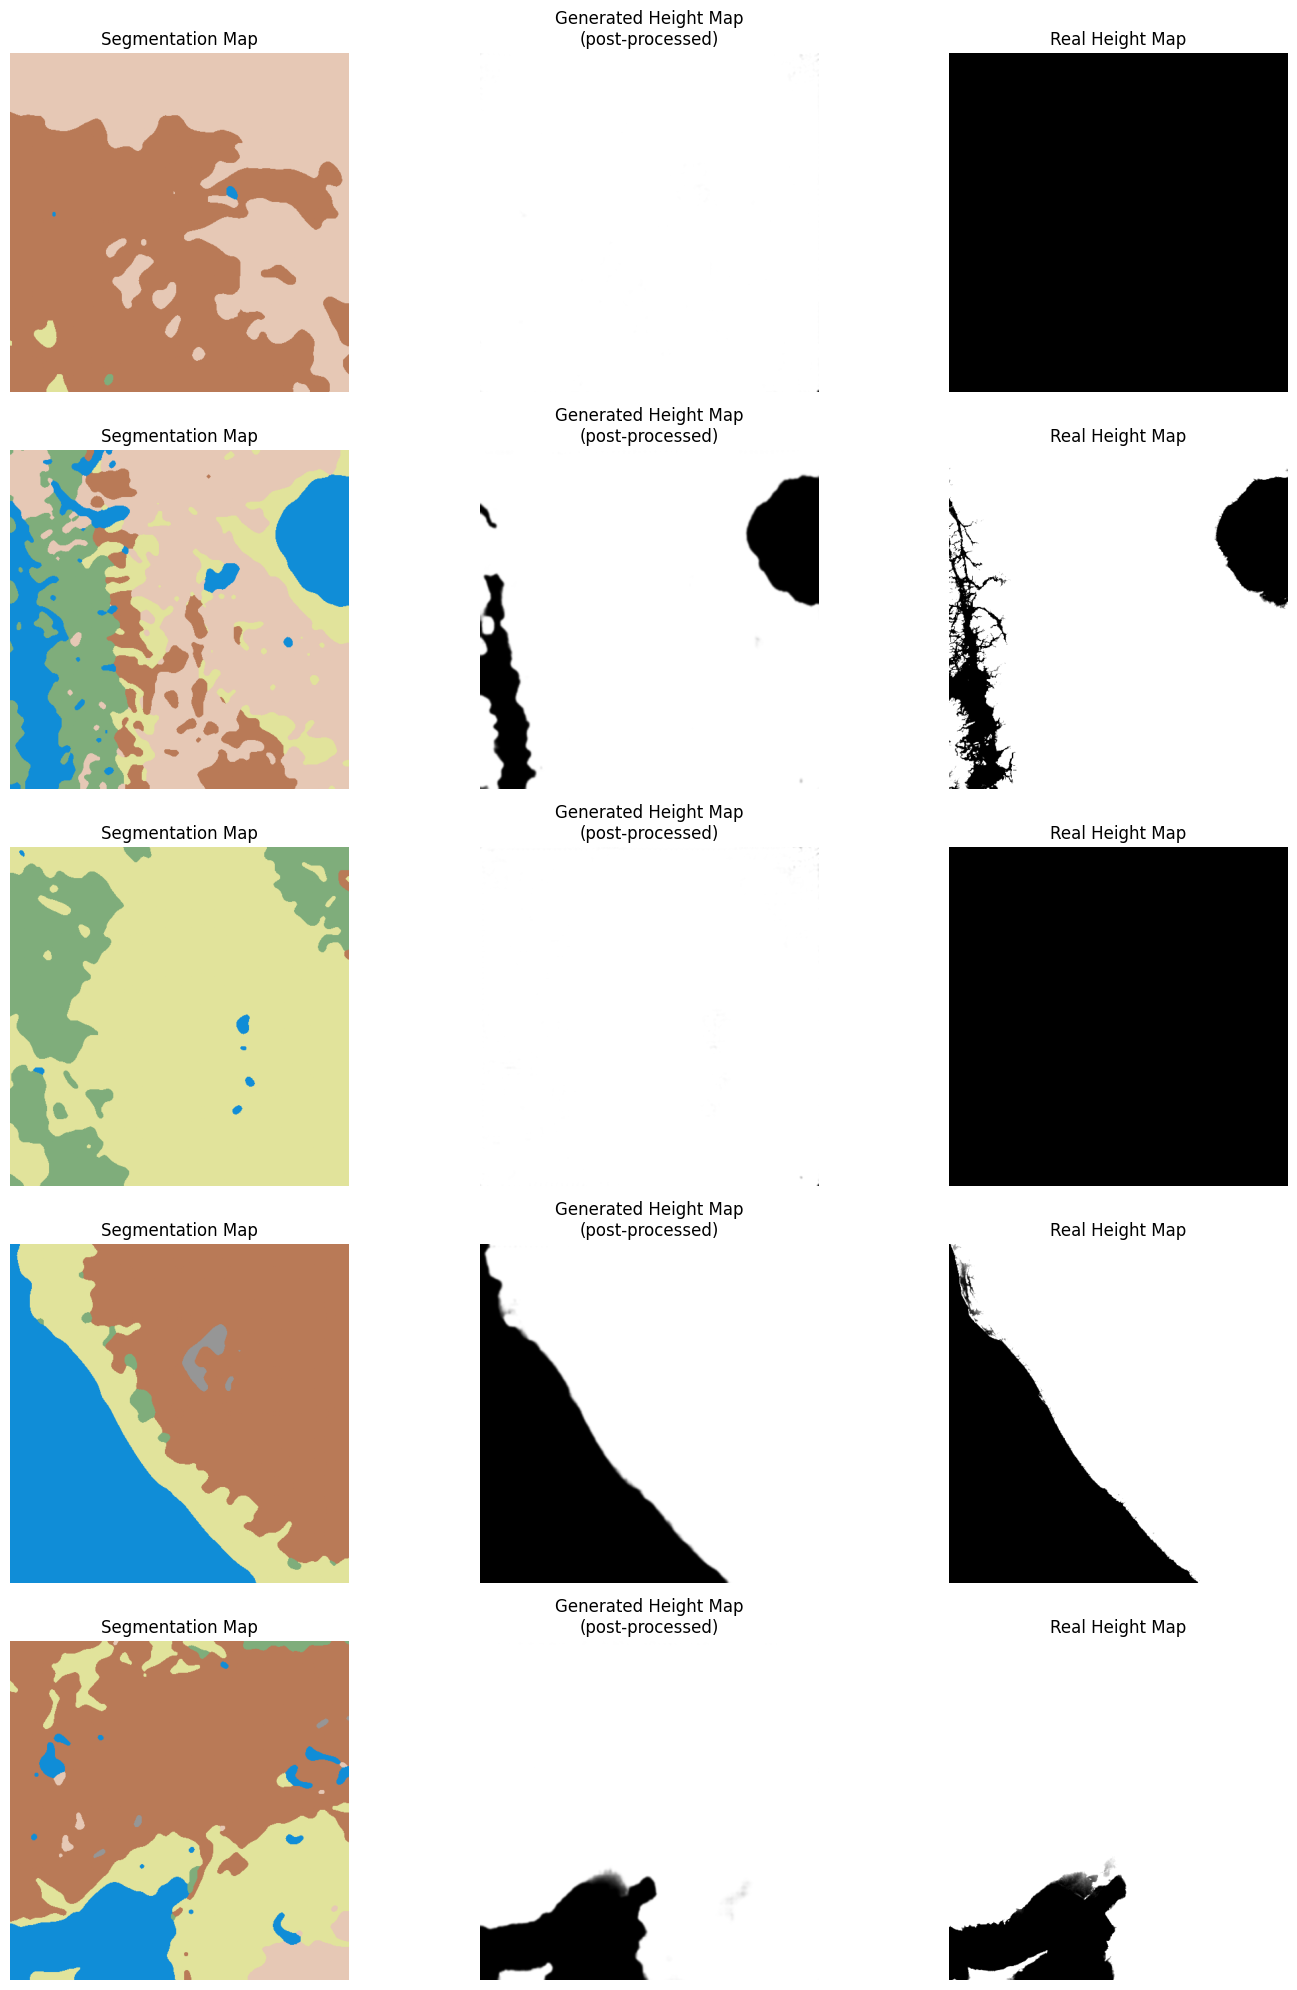

In [19]:
# ===================================================
# 7. Inference and Visualization (with Post-Processing)
# ===================================================
num_examples = 5
fig, axs = plt.subplots(num_examples, 3, figsize=(15, 4*num_examples))

for i, (seg, real_height) in enumerate(test_loader):
    if i >= num_examples:
        break

    seg = seg.to(device)
    real_height = real_height.to(device)

    # --- Run generator ---
    with torch.no_grad():
        fake_height = netG(seg)

    # --- Denormalize into original range ---
    fake_denorm = denormalize_height_map(fake_height[0])   # shape (1,H,W)
    real_denorm = denormalize_height_map(real_height[0])   # shape (1,H,W)

    # --- To NumPy for post-processing ---
    fake_np = fake_denorm.squeeze(0).cpu().numpy()

    # --- Post-process: median filter + Gaussian blur + clamp ---
    fake_np = median_filter(fake_np, size=3)
    fake_np = gaussian_filter(fake_np, sigma=1)
    fake_np = np.clip(fake_np, 0.0, 1.0)

    # --- Compute & print stats on the post-processed map ---
    print(f"Sample {i+1} -- Generated (post-proc): "
          f"min={fake_np.min():.4f}, max={fake_np.max():.4f}, "
          f"mean={fake_np.mean():.4f}, std={fake_np.std():.4f}")
    real_np = real_denorm.squeeze(0).cpu().numpy()
    print(f"Sample {i+1} -- Real: "
          f"min={real_np.min():.4f}, max={real_np.max():.4f}, "
          f"mean={real_np.mean():.4f}, std={real_np.std():.4f}")

    # --- Prepare segmentation for display (back to [0,1]) ---
    seg_img = ((seg[0] * 0.5) + 0.5).permute(1,2,0).cpu().numpy()

    # --- Plot ---
    axs[i, 0].imshow(seg_img)
    axs[i, 0].set_title("Segmentation Map")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(fake_np, cmap="gray")
    axs[i, 1].set_title("Generated Height Map\n(post-processed)")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(real_np, cmap="gray")
    axs[i, 2].set_title("Real Height Map")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# # ===================================================
# # 7. Inference and Visualization
# # ===================================================
# num_examples = 5
# fig, axs = plt.subplots(num_examples, 3, figsize=(15, 4*num_examples))

# for i, (seg, real_height) in enumerate(test_loader):
#     if i >= num_examples:
#         break
#     seg = seg.to(device)
#     real_height = real_height.to(device)
    
#     with torch.no_grad():
#         fake_height = netG(seg)
#     fake_ht_np = fake_height[0, 0].cpu().numpy()   
#     # Denormalize outputs for visualization
#     fake_denorm = denormalize_height_map(fake_height[0])
#     real_denorm = denormalize_height_map(real_height[0])
    
#     # Print numeric stats
#     print(f"Sample {i+1} -- Generated: min={fake_denorm.min().item():.4f}, max={fake_denorm.max().item():.4f}, "
#           f"mean={fake_denorm.mean().item():.4f}, std={fake_denorm.std().item():.4f}")
#     print(f"Sample {i+1} -- Real:      min={real_denorm.min().item():.4f}, max={real_denorm.max().item():.4f}, "
#           f"mean={real_denorm.mean().item():.4f}, std={real_denorm.std().item():.4f}")
    
#     # Visualization: segmentation map, generated height map, real height map.
#     # For segmentation, denormalize from [-1,1] back to [0,1]
#     seg_img = ((seg[0] * 0.5) + 0.5).permute(1,2,0).cpu().numpy()
#     fake_ht_np = median_filter(fake_ht_np, size=3)
#     fake_ht_np = gaussian_filter(fake_ht_np, sigma=0.5)
    
#     axs[i, 0].imshow(seg_img)
#     axs[i, 0].set_title("Segmentation Map")
#     axs[i, 0].axis("off")
    
#     axs[i, 1].imshow(fake_denorm.squeeze(0).cpu().numpy(), cmap='gray')
#     axs[i, 1].set_title("Generated Height Map")
#     axs[i, 1].axis("off")
    
#     axs[i, 2].imshow(real_denorm.squeeze(0).cpu().numpy(), cmap='gray')
#     axs[i, 2].set_title("Real Height Map")
#     axs[i, 2].axis("off")

# plt.tight_layout()
# plt.show()

In [20]:
import os
import numpy as np
import imageio
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm

def compute_heightmap_metrics(gen_dir, real_dir, ext='png'):
    mse_list, mae_list, psnr_list, ssim_list = [], [], [], []

    # Get only matching file names (intersection)
    gen_files = sorted([f for f in os.listdir(gen_dir) if f.endswith(ext)])
    real_files = sorted([f for f in os.listdir(real_dir) if f.endswith(ext)])
    common_files = sorted(set(gen_files) & set(real_files))

    print(f"Total matched files: {len(common_files)}")

    for fname in tqdm(common_files, desc="Evaluating"):
        gen_path = os.path.join(gen_dir, fname)
        real_path = os.path.join(real_dir, fname)

        try:
            gen = imageio.imread(gen_path).astype(np.float32)
            real = imageio.imread(real_path).astype(np.float32)

            # Normalize to [0,1] if values are in higher range
            if gen.max() > 1.0:
                gen /= 255.0
            if real.max() > 1.0:
                real /= 255.0

            # Flatten
            gen_flat = gen.flatten()
            real_flat = real.flatten()

            # Metrics
            mse = np.mean((gen_flat - real_flat) ** 2)
            mae = np.mean(np.abs(gen_flat - real_flat))
            psnr_val = psnr(real, gen, data_range=1.0)
            ssim_val = ssim(real, gen, data_range=1.0)

            mse_list.append(mse)
            mae_list.append(mae)
            psnr_list.append(psnr_val)
            ssim_list.append(ssim_val)

        except Exception as e:
            print(f"⚠️ Skipped {fname} due to error: {e}")
            continue

    return {
        "MSE": np.mean(mse_list),
        "MAE": np.mean(mae_list),
        "PSNR": np.mean(psnr_list),
        "SSIM": np.mean(ssim_list),
    }

In [21]:
import os

def rename_images(folder_path, prefix="", ext="png"):
    files = sorted([f for f in os.listdir(folder_path) if f.endswith(ext)])
    for i, filename in enumerate(files):
        new_name = f"{i:04d}.{ext}"
        src = os.path.join(folder_path, filename)
        dst = os.path.join(folder_path, new_name)
        os.rename(src, dst)
    print(f"Renamed {len(files)} files in {folder_path}")

rename_images("gen_images", ext="png")
rename_images("real_images", ext="png")

Renamed 561 files in gen_images
Renamed 1000 files in real_images


In [22]:
gen_images = r"gen_images"
real_images = r"real_images"

results = compute_heightmap_metrics(gen_images, real_images, ext='png')

print("📊 Evaluation Results:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

Total matched files: 561


Evaluating:   0%|          | 0/561 [00:00<?, ?it/s]C:\Users\TEJAS\AppData\Local\Temp\ipykernel_19272\1410113778.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gen = imageio.imread(gen_path).astype(np.float32)
C:\Users\TEJAS\AppData\Local\Temp\ipykernel_19272\1410113778.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  real = imageio.imread(real_path).astype(np.float32)
Evaluating: 100%|██████████| 561/561 [00:35<00:00, 15.82it/s]

📊 Evaluation Results:
MSE: 0.0947
MAE: 0.2163
PSNR: 13.6230
SSIM: 0.6625
